# Linear and Quadratic Discriminant Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

We'll begin by reading in the train and test sets.

In [7]:
train_full = pd.read_csv('train.csv')
test_full = pd.read_csv('test.csv')
train_full

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.950,20.01,114.20,982.0,0.08402,0.06722,0.072930,0.055960,0.2129,...,20.58,27.83,129.20,1261.0,0.10720,0.12020,0.22490,0.11850,0.4882,0.06111
1,M,13.000,21.82,87.50,519.8,0.12730,0.19320,0.185900,0.093530,0.2350,...,15.49,30.73,106.20,739.3,0.17030,0.54010,0.53900,0.20600,0.4378,0.10720
2,M,15.300,25.27,102.40,732.4,0.10820,0.16970,0.168300,0.087510,0.1926,...,20.27,36.71,149.30,1269.0,0.16410,0.61100,0.63350,0.20240,0.4027,0.09876
3,B,13.530,10.94,87.91,559.2,0.12910,0.10470,0.068770,0.065560,0.2403,...,14.08,12.49,91.36,605.5,0.14510,0.13790,0.08539,0.07407,0.2710,0.07191
4,B,11.300,18.19,73.93,389.4,0.09592,0.13250,0.154800,0.028540,0.2054,...,12.58,27.96,87.16,472.9,0.13470,0.48480,0.74360,0.12180,0.3308,0.12970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,B,9.683,19.34,61.05,285.7,0.08491,0.05030,0.023370,0.009615,0.1580,...,10.93,25.59,69.10,364.2,0.11990,0.09546,0.09350,0.03846,0.2552,0.07920
396,B,13.500,12.71,85.69,566.2,0.07376,0.03614,0.002758,0.004419,0.1365,...,14.97,16.94,95.48,698.7,0.09023,0.05836,0.01379,0.02210,0.2267,0.06192
397,B,12.750,16.70,82.51,493.8,0.11250,0.11170,0.038800,0.029950,0.2120,...,14.45,21.74,93.63,624.1,0.14750,0.19790,0.14230,0.08045,0.3071,0.08557
398,M,23.210,26.97,153.50,1670.0,0.09509,0.16820,0.195000,0.123700,0.1909,...,31.01,34.51,206.00,2944.0,0.14810,0.41260,0.58200,0.25930,0.3103,0.08677


The train and test data tables have a column `diagnosis` that we should use as the labels. We'll split this off into its own vector. Each entry of the column is either "B" (for benign) or "M" (for malignant). We'll convert this to `True`/`False`:

In [8]:
train_y = train_full.iloc[:, 0] == 'M'
train_X = train_full.iloc[:,1:]
test_y = test_full.iloc[:, 0] == 'M'
test_X = test_full.iloc[:,1:]

# Plots

Let's make scatter plots of radius vs. texture. We want one scatter plot for each class so that we can see if there is any separation:

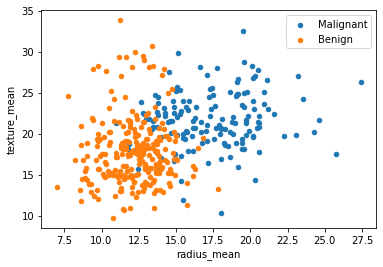

In [12]:
ax = train_X[train_y].plot(kind='scatter', x='radius_mean', y='texture_mean', label='Malignant')
train_X[~train_y].plot(kind='scatter', x='radius_mean', y='texture_mean', ax=ax, color='C1', label='Benign')
plt.savefig('scatter.pdf', bbox_inches='tight')

Here we see that the distribution of the malignant tumors is quite different from the distribution of the benign tumors. Fitting Gaussians to each class separately looks like it will be a good way to make predictions.

# Standardization

The question asks us to standardize the data before performing LDA and QDA. We compute the mean and standard deviation of each feature in the training set:

In [17]:
mu = train_X.mean(axis=0)
sigma = train_X.std(axis=0)

We then standardize both the training and test set with these statistics:

In [18]:
train_X_std = (train_X - mu)/sigma
test_X_std = (test_X - mu)/sigma

## Linear Discriminant Analysis

In part (b), we're asked to perform LDA by estimating each class-conditional density with a diagonal covariance matrix. Remember that in LDA, both covariance matrices must be the same! So we have to compute a "shared' covariance matrix. In the lecture, we saw that we can do this by fitting diagonal covariance matrices $C_1$ and $C_0$ to each class (malignant and benign) and combining them by weighted average: $(n_1 C_1 + n_0 C_0)/ (n_1 + n_0)$.

But to get started, we need to compute diagonal covariance matrices for each class, separately. Remember that the diagonal entries of the covariance matrix are just the variances of each feature. So to compute the diagonal covariance matrix, we simply compute the variances and put them into the diagonal of a square matrix. Here's a helper function that does just that:

In [19]:
def fit_diagonal_gaussian(X):
    mu = X.mean(axis=0)
    C = np.diag(X.var())
    return mu, C

Now we compute the mean of each class and the diagonal covariance for each class:

In [20]:
mu_1, C_1 = fit_diagonal_gaussian(train_X_std[train_y])
mu_0, C_0 = fit_diagonal_gaussian(train_X_std[~train_y])

We then combine the covariance matrices:

In [24]:
n = len(train_X_std)
n_1 = train_y.sum()
n_0 = n - n_1

C = (n_1 * C_1 + n_0 * C_0) / (n_1 + n_0)

Now we need to evaluate the Bayes Classifier. First we'll make predictions on the training set, then on the test set. Remember that we pick the class which maximizes:

$$
P(X = \vec x | Y = y_i) P(Y = y_i)
$$

In this case, $P(Y = 1) = n_1/n$ and $P(Y = 0) = n_0/n$, and $P(X = \vec x | Y= y_i)$ is given by evaluating the multivariate normal distributions fit above:

In [29]:
p_1 = scipy.stats.multivariate_normal.pdf(train_X_std, mu_1, C) * n_1 / n
p_0 = scipy.stats.multivariate_normal.pdf(train_X_std, mu_0, C) * n_0 / n

We predict "Malignant" if $p_1 > p_0$. Here are the predictions on the training set.

In [30]:
train_predictions = p_1 > p_0

Let's calculate the accuracy (how many times is our prediction right?)

In [31]:
(train_predictions == train_y).mean()

0.94

The error is the inverse of this: 1 - accuracy.

In [32]:
1 - (train_predictions == train_y).mean()

0.06000000000000005

Next we evaluate on the test set:

In [33]:
p_1_test = scipy.stats.multivariate_normal.pdf(test_X_std, mu_1, C) * n_1 / n
p_0_test = scipy.stats.multivariate_normal.pdf(test_X_std, mu_0, C) * n_0 / n

Here is the test error:

In [35]:
1 - ((p_1_test > p_0_test) == test_y).mean()

0.059171597633136064

## Full Gaussians

In part (c), we're asked to do QDA by estimating each class-conditional density with a full Gaussian. Remember that the difference between QDA and LDA is that we do not use the same covariance matrix for both classes (it isn't about using diagonal or full covariances. We could do LDA with a full covariance.).

In lecture, we saw that one way of computing the empirical covariance matrix of a set of vectors is to place all of the vectors into the rows of an $n \times d$ matrix (where $n$ is the number of data vectors), and to compute $(X - \vec \mu)^T (X - \vec \mu) / n$, where $\vec \mu$ is the mean of the data vectors. Here's a helper function that does just this:

In [36]:
def fit_gaussian(X):
    mu = X.mean(axis=0)
    C = (X - mu).T @ (X - mu) / len(X)
    return mu, C

In [39]:
mu_1, C_1 = fit_gaussian(train_X_std[train_y])
mu_0, C_0 = fit_gaussian(train_X_std[~train_y])

Here is the performance on the training set:

In [40]:
p_1 = scipy.stats.multivariate_normal.pdf(train_X_std, mu_1, C_1) * n_1 / n
p_0 = scipy.stats.multivariate_normal.pdf(train_X_std, mu_0, C_0) * n_0 / n

In [41]:
1 - ((p_1 > p_0) == train_y).mean()

0.03249999999999997

And here is the error on the test set:

In [42]:
p_1_test = scipy.stats.multivariate_normal.pdf(test_X_std, mu_1, C_1) * n_1 / n
p_0_test = scipy.stats.multivariate_normal.pdf(test_X_std, mu_0, C_0) * n_0 / n

In [43]:
1 - ((p_1_test > p_0_test) == test_y).mean()

0.029585798816568087